In [1]:
import torch, os
torch.manual_seed(0) 
import warnings;warnings.filterwarnings("ignore")
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst
from HINT.molecule_encode import MPNN, ADMET 
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol_encode import Protocol_Embedding
from HINT.model import HINTModel 
device = torch.device("cuda:0")  ## cuda:0
if not os.path.exists("figure"):
	os.makedirs("figure")

In [2]:
base_name = 'phase_II' ### 'toy', 'phase_I', 'phase_II', 'phase_III', 'indication'
datafolder = "data"
train_file = os.path.join(datafolder, base_name + '_train.csv')
valid_file = os.path.join(datafolder, base_name + '_valid.csv')
test_file = os.path.join(datafolder, base_name + '_test.csv')

In [3]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
admet_model_path = "save_model/admet_model.ckpt"
if not os.path.exists(admet_model_path):
	admet_dataloader_lst = generate_admet_dataloader_lst(batch_size=32)
	admet_trainloader_lst = [i[0] for i in admet_dataloader_lst]
	admet_testloader_lst = [i[1] for i in admet_dataloader_lst]
	admet_model = ADMET(molecule_encoder = mpnn_model, 
						highway_num=2, 
						device = device, 
						epoch=3, 
						lr=5e-4, 
						weight_decay=0, 
						save_name = 'admet_')
	admet_model.train(admet_trainloader_lst, admet_testloader_lst)
	torch.save(admet_model, admet_model_path)
else:
	admet_model = torch.load(admet_model_path)
	admet_model = admet_model.to(device)
	admet_model.set_device(device)

In [4]:
train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=64) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader  = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

In [5]:
print(train_loader.dataset.label_lst.count('1'), train_loader.dataset.label_lst.count('0'))
print(valid_loader.dataset.label_lst.count('1'), valid_loader.dataset.label_lst.count('0'))
print(test_loader.dataset.label_lst.count('1'), test_loader.dataset.label_lst.count('0'))

1914 2091
208 238
918 736


In [6]:
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = Protocol_Embedding(output_dim = 50, highway_num=3, device = device)

PR-AUC   mean: 0.6151 std: 0.0116
F1       mean: 0.6403 std: 0.0102
ROC-AUC  mean: 0.6264 std: 0.0133
NCT01288573 1 0.3901
NCT01450826 0 0.5877
NCT01562197 1 0.4466
NCT01610869 1 0.3889
NCT01641107 0 0.5693
NCT01717053 1 0.3880
NCT01781975 1 0.4837
NCT01806571 1 0.4008
NCT01812616 1 0.4046
NCT01836289 0 0.5264
NCT01928927 0 0.6536
NCT01930864 1 0.3705
NCT01934192 0 0.5151
NCT01937117 1 0.4063
NCT01945866 0 0.6369
NCT01949116 0 0.6252
NCT01950299 1 0.4053
NCT01955707 0 0.6619
NCT01966731 1 0.3947
NCT01972217 1 0.3850
NCT01972347 1 0.4073
NCT01975662 0 0.5586
NCT01977820 0 0.5204
NCT01984242 1 0.3440
NCT01986751 0 0.5820
NCT01988493 1 0.3449
NCT01992952 1 0.4074
NCT02006472 0 0.5759
NCT02008773 0 0.5631
NCT02011451 0 0.7089
NCT02013128 1 0.4909
NCT02013362 1 0.4548
NCT02021292 1 0.3509
NCT02021669 0 0.5390
NCT02023697 0 0.6321
NCT02024932 1 0.4022
NCT02025985 1 0.3503
NCT02029638 0 0.5093
NCT02031081 0 0.6872
NCT02031458 1 0.3448
NCT02033278 0 0.6335
NCT02033993 1 0.4071
NCT02037230 1 0.

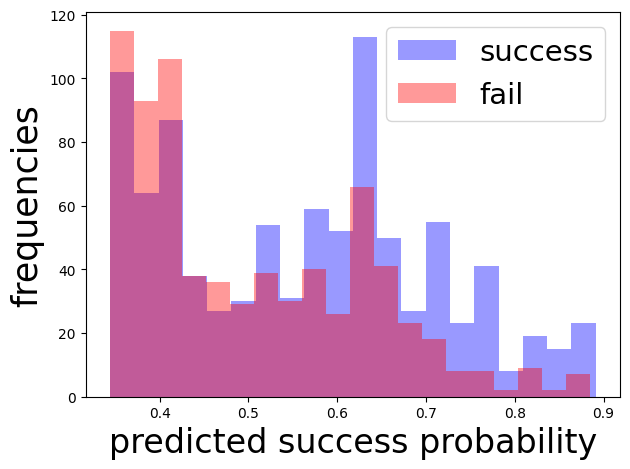

In [7]:
hint_model_path = "save_model/" + base_name + ".ckpt"
if not os.path.exists(hint_model_path):
	model = HINTModel(molecule_encoder = mpnn_model, 
			disease_encoder = gram_model, 
			protocol_encoder = protocol_model,
			device = device, 
			global_embed_size = 50, 
			highway_num_layer = 2,
			prefix_name = base_name, 
			gnn_hidden_size = 50,  
			epoch = 15,
			lr = 5e-4, 
			weight_decay = 1e-3, 
			)
	model.init_pretrain(admet_model)
	train_output, valid_output = model.learn(train_loader, valid_loader, test_loader)
	nctid_all, predict_all = model.bootstrap_test(test_loader, valid_loader=valid_loader)
	torch.save(model, hint_model_path)
else:
	model = torch.load(hint_model_path)
	model.bootstrap_test(test_loader)
	train_loss, train_predict, train_label = model.test(train_loader, return_loss=True)
	test_loss, test_predict, test_label = model.test(test_loader, return_loss=True)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [9]:
n = len(test_predict)
test_predict_label = [0] * n
for i in range(n):
    if test_predict[i] > 0.5:
        test_predict_label[i] = 1

accuracy_score(test_predict_label, test_label)

0.599758162031439

In [10]:
n = len(train_predict)
train_predict_label = [0] * n
for i in range(n):
    if train_predict[i] > 0.5:
        train_predict_label[i] = 1

accuracy_score(train_predict_label, train_label)
# len(test_label)
# sum(test_label) / len(test_label)


0.6544319600499375

In [11]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq
from scipy.stats import binom
import seaborn as sns
from copy import deepcopy 

In [24]:
smx = np.array(train_predict)
labels = np.array(train_label)
# smx = np.array(test_predict)
# labels = np.array(test_label)
a = 1-smx
smx = np.vstack((a, smx))
smx = smx.transpose()
smx.shape

(4005, 2)

In [25]:
labels.sum() / len(labels)

0.4779026217228464

In [26]:
n = 400
alpha = 0.2
delta = 0.3

In [90]:
lambdas = np.linspace(0,1,501)
prauc = []
f1 = []
rocauc = []
selective_accuracy = []
improved_accuracy = []
points_kept = []

for i in range(20):
    # Split the softmax scores into calibration and validation sets (save the shuffling)
    idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
    np.random.shuffle(idx)
    cal_smx, val_smx = smx[idx,:], smx[~idx,:]
    cal_labels, val_labels = labels[idx], labels[~idx]
    # Yhat, Phat
    cal_yhats = np.argmax(cal_smx, axis=1); val_yhats = np.argmax(val_smx, axis=1)
    cal_phats = np.max(cal_smx, axis=1); val_phats = np.max(val_smx, axis=1)


    # Define selective risk
    def selective_risk(lam): 
        return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
    def nlambda(lam): 
        return (cal_phats > lam).sum()
    def invert_for_ub(r,lam): 
        return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
    # Construct upper boud
    def selective_risk_ub(lam): 
        return brentq(invert_for_ub,0.1,0.9999,args=(lam,))
    # Make sure there's some data in the top bin.
    lambdas = np.array([lam for lam in lambdas if nlambda(lam) >= 200]) 
    # Scan to choose lamabda hat
    for lhat in np.flip(lambdas):
        # print(lhat)
        print(lhat, selective_risk_ub(lhat-1/lambdas.shape[0]), selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha)
        if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break
    # Deploy procedure on test data
    predictions_kept = val_phats >= lhat


    from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, accuracy_score
    # Calculate empirical selective accuracy

    test_accuracy = accuracy_score(test_predict_label, test_label)
    empirical_selective_accuracy = (val_yhats[predictions_kept] == val_labels[predictions_kept]).mean()
    empirical_improved_accuracy = empirical_selective_accuracy - test_accuracy
    fraction_kept = predictions_kept.mean()

    val_label_kept = val_labels[predictions_kept]
    val_pred_kept = val_yhats[predictions_kept]
    val_score_kept = val_smx[:,1][predictions_kept]

    prauc_score = average_precision_score(val_label_kept, val_score_kept)
    f1score = f1_score(val_label_kept, val_pred_kept)
    auc_score = roc_auc_score(val_label_kept, val_score_kept)
    precision = precision_score(val_label_kept, val_pred_kept)
    recall = recall_score(val_label_kept, val_pred_kept)
    accuracy = accuracy_score(val_label_kept, val_pred_kept)
    predict_1_ratio = sum(val_pred_kept) / len(val_pred_kept)
    label_1_ratio = sum(val_label_kept) / len(val_label_kept)

    prauc.append(prauc_score)
    f1.append(f1score)
    rocauc.append(auc_score)
    selective_accuracy.append(empirical_selective_accuracy)
    improved_accuracy.append(empirical_improved_accuracy)
    points_kept.append(fraction_kept)

print(f"The original accuracy is:\t\t{test_accuracy:.4F}")
print(f"The empirical selective accuracy is:\tmean: {np.mean(selective_accuracy):.4F}\tstd: {np.std(selective_accuracy):.4f}")
print(f"The empirical improved accuracy is:\tmean: {np.mean(improved_accuracy):.4F}\tstd: {np.std(improved_accuracy):.4f}")
print(f"The fraction of data points kept is:\tmean: {np.mean(points_kept):.4F}\tstd: {np.std(points_kept):.4f}")

print(f"PR_AUC\t mean: {np.mean(prauc):.4F}\tstd: {np.std(prauc):.4f}")
print(f"F1\t mean: {np.mean(f1):.4F}\tstd: {np.std(f1):.4f}")
print(f"ROC_AUC  mean: {np.mean(rocauc):.4F}\tstd: {np.std(rocauc):.4f}")


0.606 0.30790568509207167 True
0.606 0.32096140868615897 True
0.606 0.33904773755324763 True
0.606 0.3074533328610633 True
0.606 0.30138081957163754 True
0.606 0.22859706905396743 True
0.606 0.27955151104993853 True
0.606 0.31673124581159606 True
0.606 0.29591092385757284 True
0.606 0.37160233633815026 True
0.606 0.3358479531573307 True
0.606 0.31641877499002047 True
0.606 0.29918087214431033 True
0.606 0.28761707476917925 True
0.606 0.312350375868618 True
0.606 0.2774408944967688 True
0.606 0.2842380463596366 True
0.606 0.27228226886500445 True
0.606 0.32200812454821004 True
0.606 0.308325955674768 True
The original accuracy is:		0.5998
The empirical selective accuracy is:	mean: 0.7002	std: 0.0031
The empirical improved accuracy is:	mean: 0.1005	std: 0.0031
The fraction of data points kept is:	mean: 0.5414	std: 0.0021
PR_AUC	 mean: 0.7399	std: 0.0055
F1	 mean: 0.7224	std: 0.0036
ROC_AUC  mean: 0.7299	std: 0.0038


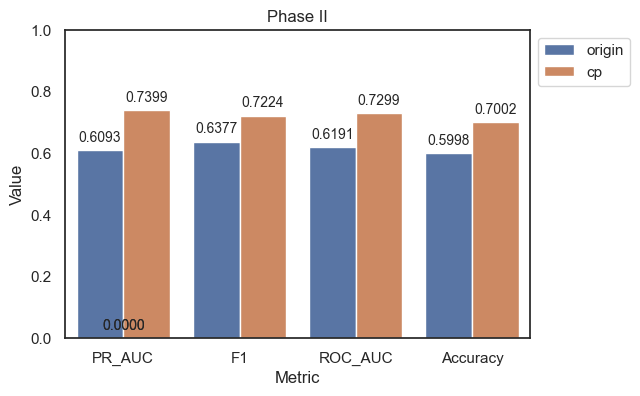

In [91]:
# PR-AUC   mean: 0.6093 std: 0.0131
# F1       mean: 0.6377 std: 0.0110
# ROC-AUC  mean: 0.6191 std: 0.0116

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

origin = [0.6093, 0.6377, 0.6191, accuracy_score(test_predict_label, test_label)]
cp = [np.mean(prauc), np.mean(f1), np.mean(rocauc), np.mean(selective_accuracy)]


# X axis
X_labels = ["PR_AUC", "F1", "ROC_AUC", "Accuracy"]

import pandas as pd

data = {
    'Metric': X_labels * 2,  
    'Value': origin + cp,  
    'Type': ['origin']*4 + ['cp']*4  
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Metric', y='Value', hue='Type', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize = 10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Phase II')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.ylim(0, 1)

# 显示图形
plt.show()


In [92]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]
# Yhat, Phat
cal_yhats = np.argmax(cal_smx, axis=1); val_yhats = np.argmax(val_smx, axis=1)
cal_phats = np.max(cal_smx, axis=1); val_phats = np.max(val_smx, axis=1)

In [93]:
# Define selective risk
def selective_risk(lam): 
    return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
def nlambda(lam): 
    return (cal_phats > lam).sum()
def invert_for_ub(r,lam): 
    return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
# Construct upper boud
def selective_risk_ub(lam): 
    return brentq(invert_for_ub,0.1,0.9999,args=(lam,))
# Make sure there's some data in the top bin.
lambdas = np.array([lam for lam in lambdas if nlambda(lam) >= 150]) 
# Scan to choose lamabda hat
for lhat in np.flip(lambdas):
    # print(lhat)
    if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break
# Deploy procedure on test data
predictions_kept = val_phats >= lhat
lhat

0.606

In [94]:
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, accuracy_score
# Calculate empirical selective accuracy

test_accuracy = accuracy_score(test_predict_label, test_label)
print(f"The original  accuracy is:\t\t{test_accuracy:.4F}")
empirical_selective_accuracy = (val_yhats[predictions_kept] == val_labels[predictions_kept]).mean()
print(f"The empirical selective accuracy is:\t{empirical_selective_accuracy:.4F}")
improved_accuracy = empirical_selective_accuracy - test_accuracy
print(f"The improved accuracy is:\t\t{improved_accuracy:.4F}")
# false_flags = (val_yhats[~predictions_kept] == val_labels[~predictions_kept]).mean()
# print(f"The fraction of false flags is:\t\t{false_flags:.4F}")
fraction_kept = predictions_kept.mean()
print(f"The fraction of data points kept is:\t{fraction_kept:.4F}")

val_label_kept = val_labels[predictions_kept]
val_pred_kept = val_yhats[predictions_kept]
val_score_kept = val_smx[:,1][predictions_kept]

prauc_score = average_precision_score(val_label_kept, val_score_kept)
print(f"PR_AUC:\t\t{prauc_score:.4F}")
f1score = f1_score(val_label_kept, val_pred_kept)
print(f"F1:\t\t{f1score:.4F}")
auc_score = roc_auc_score(val_label_kept, val_score_kept)
print(f"ROC_AUC:\t{auc_score:.4F}")

precision = precision_score(val_label_kept, val_pred_kept)
print(f"precision:\t{precision:.4F}")
recall = recall_score(val_label_kept, val_pred_kept)
print(f"recall:\t\t{recall:.4F}")
accuracy = accuracy_score(val_label_kept, val_pred_kept)
print(f"accuracy:\t{accuracy:.4F}")
predict_1_ratio = sum(val_pred_kept) / len(val_pred_kept)
print(f"pred_1_ratio:\t{predict_1_ratio:.4F}")
label_1_ratio = sum(val_label_kept) / len(val_label_kept)
print(f"label_1_ratio:\t{label_1_ratio:.4F}")


The original  accuracy is:		0.5998
The empirical selective accuracy is:	0.7040
The improved accuracy is:		0.1043
The fraction of data points kept is:	0.5445
PR_AUC:		0.7390
F1:		0.7243
ROC_AUC:	0.7328
precision:	0.7071
recall:		0.7422
accuracy:	0.7040
pred_1_ratio:	0.5497
label_1_ratio:	0.5237


In [95]:
import pandas as pd

train_csv = pd.read_csv(test_file, delimiter=',')
nctids = list(train_csv['nctid'])

_ncts   = []
_keeps  = []
_yhats  = []
_labels = []
_smx    = []

for i in range(10):
    rand_nct = np.random.choice(nctids)
    _ncts.append(rand_nct)
    # print(rand_nct, nctids.index(rand_nct))
    idx = nctids.index(rand_nct)
    _smx.append(smx[idx][1])
    _keeps.append(np.max(smx[idx]) >= lhat)
    _yhats.append([np.argmax(smx[idx])])
    _labels.append(labels[idx])

for i in range(len(_ncts)):
    print(f"nctid: {rand_nct} | Probability: {_smx[i]:.4f} | Prediction: {_yhats[i][0]} | Label: {_labels[i]} | Abstained: {~_keeps[i]}")


nctid: NCT02378870 | Probability: 0.4056 | Prediction: 0 | Label: 1 | Abstained: True
nctid: NCT02378870 | Probability: 0.3448 | Prediction: 0 | Label: 0 | Abstained: False
nctid: NCT02378870 | Probability: 0.6570 | Prediction: 1 | Label: 0 | Abstained: False
nctid: NCT02378870 | Probability: 0.5618 | Prediction: 1 | Label: 0 | Abstained: True
nctid: NCT02378870 | Probability: 0.4909 | Prediction: 0 | Label: 1 | Abstained: True
nctid: NCT02378870 | Probability: 0.6411 | Prediction: 1 | Label: 0 | Abstained: False
nctid: NCT02378870 | Probability: 0.6170 | Prediction: 1 | Label: 1 | Abstained: False
nctid: NCT02378870 | Probability: 0.3942 | Prediction: 0 | Label: 0 | Abstained: True
nctid: NCT02378870 | Probability: 0.6272 | Prediction: 1 | Label: 1 | Abstained: False
nctid: NCT02378870 | Probability: 0.3832 | Prediction: 0 | Label: 1 | Abstained: False


In [96]:
def selective_risk2(lam): 
    return (val_yhats[val_phats >= lam] != val_labels[val_phats >= lam]).sum()/(val_phats >= lam).sum()

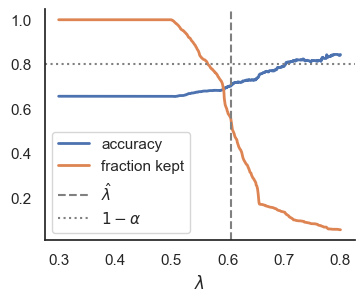

In [97]:
import seaborn as sns

lambdas = np.linspace(0.3,0.8,1000)
sns.set(style='white')
selective_accuracy_curve = [1-selective_risk2(lam) for lam in lambdas]
fraction_kept_curve = [(val_phats >= lam).mean() for lam in lambdas]
fig, axs = plt.subplots(1,1,figsize=(4,3))
axs.plot(lambdas,selective_accuracy_curve,label='accuracy',linewidth=2)
axs.plot(lambdas,fraction_kept_curve,label='fraction kept',linewidth=2)
axs.axvline(x=lhat,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}$',color='gray')
axs.axhline(y=1-alpha,linewidth=1.5,linestyle='dotted',label=r'$1-\alpha$',color='gray')
sns.despine(ax=axs,top=True,right=True)
axs.legend(loc='lower left')
axs.set_xlabel(r'$\lambda$')
plt.show()

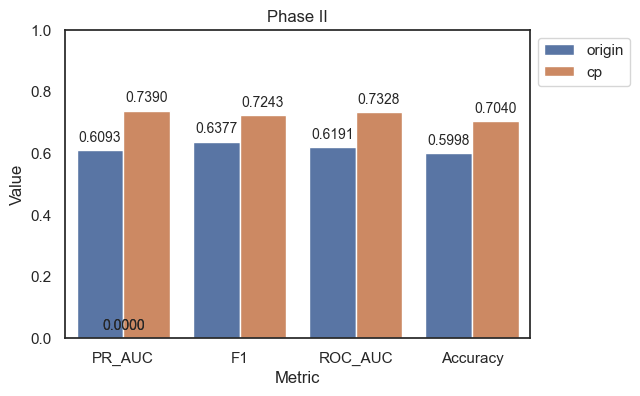

In [98]:
# PR-AUC   mean: 0.6093 std: 0.0131
# F1       mean: 0.6377 std: 0.0110
# ROC-AUC  mean: 0.6191 std: 0.0116

import matplotlib.pyplot as plt
import seaborn as sns

origin = [0.6093, 0.6377, 0.6191, accuracy_score(test_predict_label, test_label)]
cp = [prauc_score, f1score, auc_score, empirical_selective_accuracy]

# X axis
X_labels = ["PR_AUC", "F1", "ROC_AUC", "Accuracy"]

import pandas as pd

data = {
    'Metric': X_labels * 2,  
    'Value': origin + cp,  
    'Type': ['origin']*4 + ['cp']*4  
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Metric', y='Value', hue='Type', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize = 10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Phase II')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.ylim(0, 1)

# 显示图形
plt.show()
